### Random Forest

In [34]:
import numpy as np
import matplotlib.pyplot as plt

In [35]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import make_blobs

iris = load_breast_cancer()
X = iris.data
y = iris.target

# X, y = make_blobs(n_samples=3000, centers=4,random_state=40, cluster_std=1.0)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, shuffle=True, random_state=42)

print('======= Train =======')
print(X_train.shape,y_train.shape)
print('======= Test =======')
print(X_test.shape,y_test.shape)

======= Train =======
(398, 30) (398,)
======= Test =======
(171, 30) (171,)


In [36]:
import random, math
from sklearn.tree import DecisionTreeClassifier
from scipy import stats
from sklearn.metrics import classification_report, accuracy_score

class RandomForest:
    def __init__(self, B, bootstrap_ratio, with_no_replacement=True):
        self.B = B
        self.bootstrap_ratio = bootstrap_ratio
        self.with_no_replacement = with_no_replacement
        ######### max_features = 'sqrt'
        self.tree_params = {'max_depth': 2, 'max_features': 'sqrt'}
        self.models = [DecisionTreeClassifier(**self.tree_params) for _ in range(B)]
                
    def fit(self, X, y):  #<---X_train, y_train
        m, n = X.shape

        #sample size for each tree
        sample_size = int(self.bootstrap_ratio * len(X))

        xsamples = np.zeros((B, sample_size, n))
        ysamples = np.zeros((B, sample_size))

        xsamples_oob = []  #use list because length is not known
        ysamples_oob = []

        #bootstrapping samples for each model
        for i in range(self.B):
            oob_idx = []
            idxes = []
            for j in range(sample_size):
                idx = random.randrange(m)
                if (self.with_no_replacement):
                    while idx in idxes:
                        idx = random.randrange(m)
                idxes.append(idx)
                oob_idx.append(idx)
                xsamples[i, j, :] = X[idx]
                ysamples[i, j] = y[idx]
            mask = np.zeros((m), dtype=bool)
            mask[oob_idx] = True
            xsamples_oob.append(X[~mask])
            ysamples_oob.append(y[~mask])
    
        #fitting each estimator
        oob_score = 0
        print("======Out of bag score for each tree======")
        for i, model in enumerate(self.models):
            
            _X = xsamples[i]
            _y = ysamples[i]
            model.fit(_X, _y)

            #calculating oob score
            _X_test = np.asarray(xsamples_oob[i])
            _y_test = np.asarray(ysamples_oob[i])
            yhat = model.predict(_X_test)
            oob_score += accuracy_score(_y_test, yhat)
            print(f"Tree {i}", accuracy_score(_y_test, yhat))
        self.avg_oob_score = oob_score / len(self.models)
        print("======Average out of bag score======")
        print(self.avg_oob_score)
    
    def predict(self, X): #<---X_test
        #make prediction and return the probabilities
        predictions = np.zeros((self.B, X.shape[0]))
        for i, model in enumerate(self.models):
            yhat = model.predict(X)
            predictions[i, :] = yhat
        return stats.mode(predictions)[0][0]

In [37]:
B= 5
model = RandomForest(B=5, bootstrap_ratio=0.8)
model.fit(X_train, y_train)
yhat = model.predict(X_test)
print(classification_report(y_test, yhat))

======Out of bag score for each tree======
Tree 0 0.95
Tree 1 0.925
Tree 2 0.9375
Tree 3 0.9625
Tree 4 0.875
======Average out of bag score======
0.93
              precision    recall  f1-score   support

           0       0.98      0.90      0.94        63
           1       0.95      0.99      0.97       108

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



### Sklearn

In [38]:
#this is the same as RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {"n_estimators": [10, 50, 100], 
              "criterion": ["gini", "entropy"],
              "max_depth": np.arange(1, 10)}
model = RandomForestClassifier()

grid = GridSearchCV(model, param_grid)
grid.fit(X, y)

print(grid.best_params_)

model = grid.best_estimator_
model.fit(X_train, y_train)

yhat = model.predict(X_test)

print(classification_report(y_test, yhat))

{'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        63
           1       0.97      0.99      0.98       108

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



#### Extra: Feature importances


Feature ranking:
1. feature 7 (0.132203)
2. feature 27 (0.126726)
3. feature 23 (0.111534)
4. feature 20 (0.094519)
5. feature 22 (0.084825)
6. feature 2 (0.065462)
7. feature 6 (0.060880)
8. feature 26 (0.036010)
9. feature 13 (0.033872)
10. feature 21 (0.031126)
11. feature 0 (0.025519)
12. feature 1 (0.024960)
13. feature 3 (0.023594)
14. feature 10 (0.018933)
15. feature 28 (0.015736)
16. feature 25 (0.014710)
17. feature 12 (0.012062)
18. feature 24 (0.010578)
19. feature 5 (0.009654)
20. feature 19 (0.008943)
21. feature 16 (0.008781)
22. feature 15 (0.008541)
23. feature 17 (0.006591)
24. feature 4 (0.006404)
25. feature 18 (0.005873)
26. feature 29 (0.004928)
27. feature 9 (0.004821)
28. feature 14 (0.004629)
29. feature 11 (0.004585)
30. feature 8 (0.003001)


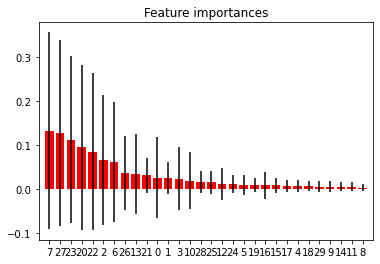

In [44]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

(398, 2)


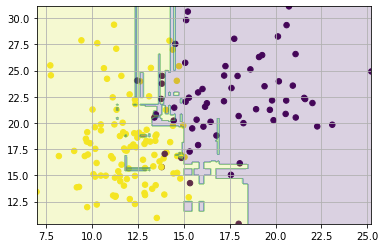

In [47]:
def plot_tree(model, X, y):
    plt.grid()
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30)
    xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]), np.max(X[:,0]), num=200),
                             np.linspace(np.min(X[:,1]), np.max(X[:,1]), num=200))
#     print(xx.shape,yy.shape)
#     print(X[:, 0].shape, X[:, 1].shape)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
#     print(Z.shape)
    # Create a color plot with the results
    n_classes = len(set(y))
    contours = plt.contourf(xx, yy, Z, alpha=0.2)

# plot_tree(bag, X_train[:,:2], y_train)    
    
########### only 2 featuresssssssss
bag = BaggingClassifier(tree, n_estimators=5, max_samples=0.99)
bag.fit(X_train[:,:2], y_train)
print(X_train[:,:2].shape)
plot_tree(bag, X_test[:,:2], y_test)